# Kinds of kindness: Experimental Results
This notebook contains the code necessary to perform the data analysis. For session 1, participants number 9 (table A3) and participant number 24 (table A1) are to be excluded because they were not able to complete the experiment. The same for participants number 4 and 17 in session 2

In [1]:
import sys
import numpy as np
sys.path.append('/Users/federicobassi/Desktop/TI.nosync/MPhil_Thesis/python/utils')
from data_cleaning import *
from utils.data_generation import *
from utils.data_plotting import *
from utils.test_rev_pref import *
from utils.maximize_utility_bc import *
from utils.budget_placement import *
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from statistics import stdev

In [32]:
main = "/Users/federicobassi/Desktop/TI.nosync/MPhil_Thesis"
save_dir = main + "/tables"
img_path = main + "/plots/experiment"
data = main + "/data"

In [3]:
mpl.rcParams.update({"font.family": "serif", "font.serif": ["Times New Roman"],"axes.titlesize": 18, "axes.titleweight": "bold",})

## 0. Setup

### 0.1 Fetch tables, remove missing

In [4]:
db_session_1 = "2508_01"
db_session_2 = "2508_02"

budget_lines = fetch_table(db_session_1, "garp")

# Session 1
s1_pp      = fetch_table(db_session_1, "ppnummers")
s1_garp    = fetch_table(db_session_1, "resultsgarp")
s1_mtask   = fetch_table(db_session_1, "resultsmtask")
s1_mtaskpp = fetch_table(db_session_1, "resultsmtaskpp")

sent_away_s1 = [9, 24]
dfs_sess_1 = [s1_pp, s1_garp, s1_mtask, s1_mtaskpp]

# Session 2
s2_pp      = fetch_table(db_session_2, "ppnummers")
s2_garp    = fetch_table(db_session_2, "resultsgarp")
s2_mtask   = fetch_table(db_session_2, "resultsmtask")
s2_mtaskpp = fetch_table(db_session_2, "resultsmtaskpp")

sent_away_s2 = [4, 17]
dfs_sess_2 = [s2_pp, s2_garp, s2_mtask, s2_mtaskpp]

for df in dfs_sess_1:
    df.drop(df[df["ppnr"].isin(sent_away_s1)].index, inplace=True)

for df in dfs_sess_2:
    df.drop(df[df["ppnr"].isin(sent_away_s2)].index, inplace=True)

In [5]:
len(s1_pp), len(s2_pp)

(26, 20)

### 0.2 Join sessions

In [6]:
# -------------------------------------- ppnummers ----------------------------------------
results_ppnummers = concat_with_ids(s1_pp, s2_pp)

# Recode the "treatment" column
results_ppnummers["pucktreatment"] = results_ppnummers["pucktreatment"].replace({1: "treatment", 2: "control", "1": "treatment", "2": "control"})

# -------------------------------------- garp ----------------------------------------------
results_garp = concat_with_ids (s1_garp, s2_garp)

budget_subset = budget_lines[['part', 'period', 'S', 'O', "direction"]]
results_garp = results_garp.merge(budget_subset, on=['part', 'period', "direction"], how='left')

results_garp = results_garp.rename(columns={'S': 'max_self', 'O': 'max_other', "zelf": "noisy_x", "ander": "noisy_y"})

# Append the treatment group
id_treatment = results_ppnummers[["id", "pucktreatment", "slopeorder"]]
results_garp = results_garp.merge(id_treatment, on=["id"], how="left")

# -------------------------------------- mtaskpp -------------------------------------------
results_mtaskpp = concat_with_ids(s1_mtaskpp, s2_mtaskpp)
results_mtaskpp = results_mtaskpp.merge(id_treatment, on=["id"], how="left")
results_mtaskpp["nrattempts"]=results_mtaskpp["nrcorrect"] + results_mtaskpp["nrwrong"]

results_mtaskpp.head()

,id,index,session,ppnr,period,slopephase,nrcorrect,nrwrong,secondsleft,part,tasktimestart,pointsprevious,pucktreatment,slopeorder,nrattempts
0,14,1,1,15,7,0,5,1,3,1,2025-06-10 14:24:27,0,treatment,2,6
1,23,3,1,25,6,0,3,2,24,1,2025-06-10 14:24:05,0,treatment,2,5
2,15,4,1,16,10,0,3,6,9,1,2025-06-10 14:26:06,0,control,2,9
3,26,5,1,28,7,0,3,3,3,1,2025-06-10 14:24:56,0,control,2,6
4,9,6,1,10,8,0,4,3,10,1,2025-06-10 14:24:46,0,control,1,7


In [37]:
results_garp.to_excel(data+"/garp.xlsx")

## 1. Analysis from the Questionnaire
Create a table for descriptive statistics based on the questionnaire for subjects in the two treatments.

In [7]:
s1_pp.columns

Index(['session', 'ppnr', 'tafelnummer', 'part', 'period', 'vrijgemaakt1',
       'currentpage', 'jovantreatment', 'jovanquestion', 'earningsJovan',
       'pucktreatment', 'earningsGarp_ds', 'earningsGarp_us', 'earningsMtask',
       'totverdeuros', 'leeftijd', 'sexe', 'studie', 'nationaliteit',
       'jaarbegin', 'jaarafstuderen', 'recivide', 'clock', 'mdifficult',
       'mfun', 'mstressfull', 'gdifficult', 'gfun', 'gstressfull',
       'commentmatrix', 'commentgarp', 'questionnairetijd', 'instructionspage',
       'matrixnr', 'slopeorder', 'slopephase', 'iban', 'bic'],
      dtype='object')

In [8]:
ppnummers_clean = tidy_questionnaire(results_ppnummers)

vars_to_check = {
            "Age": "age",
            "Female": "female",
            "Economics student": "econ_student",
            "Year begin": "year_begin",
            "Year end": "year_end",
            "Lab Experience": "creed_exp",
            "International": "international",
            "MT Difficulty": "mdifficult",
            "MT Fun": "mfun",
            "MT Stress": "mstressfull",
            "DM Difficulty": "gdifficult",
            "DM Fun": "gfun",
            "DM Stress": "gstressfull",
        }

latex_code = describe_by_group_to_latex(
        ppnummers_clean,
        vars_to_check = vars_to_check,
        group_col="pucktreatment",
        filename=save_dir+ "/describe_by_group_table.tex",
        caption="Descriptive statistics by treatment group",
        label="tab:desc_stats",
)

In [9]:
ppnummers_clean.columns

Index(['id', 'session', 'ppnr', 'tafelnummer', 'part', 'period',
       'vrijgemaakt1', 'currentpage', 'jovantreatment', 'jovanquestion',
       'earningsJovan', 'pucktreatment', 'earningsGarp_ds', 'earningsGarp_us',
       'earningsMtask', 'totverdeuros', 'leeftijd', 'sexe', 'studie',
       'nationaliteit', 'jaarbegin', 'jaarafstuderen', 'recivide', 'clock',
       'mdifficult', 'mfun', 'mstressfull', 'gdifficult', 'gfun',
       'gstressfull', 'commentmatrix', 'commentgarp', 'questionnairetijd',
       'instructionspage', 'matrixnr', 'slopeorder', 'slopephase', 'iban',
       'bic', 'age', 'female', 'econ_student', 'creed_exp', 'international',
       'year_begin', 'year_end'],
      dtype='object')

In [10]:
# Quick descriptives
print("Percentage of females: " + str(ppnummers_clean.female.sum()))
print(f"Average age: {round(ppnummers_clean.age.mean(),2)}")
print(f"Age range: {ppnummers_clean.age.min()}-{ppnummers_clean.age.max()}")
print(f"Average earnings: {round(results_ppnummers.totverdeuros.mean(),2)}")
print(f"Std earnings: {round(results_ppnummers.totverdeuros.astype(int).std(),2)}")

Percentage of females: 31
Average age: 20.78
Age range: 18-29
Average earnings: 14.48
Std earnings: 6.39


In [11]:
print("Comments for the Matrix task:\n")
for i in range(len(results_ppnummers)):
    string = results_ppnummers.commentmatrix.iloc[i]
    if string == "":
        continue
    else:
        print(string)

print("\nComments for the GARP task:\n")

for i in range(len(results_ppnummers)):
    string = results_ppnummers.commentgarp.iloc[i]
    if string == "":
        continue
    else:
        print(string)


Comments for the Matrix task:

No, everything was clear.
Why did we have to continue with the matrix task even when we were presumably over and we were no longer matched with another participant? Did being more accurate/quick in the matrix task affect our payout/outcome at all?
This was simple and easy to understand
no
The clock with the matrix was very stressful, so I do not know whether I did it right.
No other comments
I understand all the requirements and find this task a little difficult. I'm also curious whether there exists a way to fasten the process of finding the highest number cause during the experiment, the only way that I used was to skim through 2 lines at a time to cover all the numbers in the board. I'm concerned if I do not cover all the numbers, I might make mistakes.
No
everything is clear
It was straightforward
I would like to know the recommended strategy if possible, as i still wasnt able to find the pattern after a few rounds.
No
Very clear, just super repetitiv

## 2. Analysis for the Decision-Making Task

In [12]:
garp_ds = results_garp.loc[results_garp.direction==-1]
garp_ds = garp_ds.copy()

In [34]:
garp_ds

,id,index,session,ppnr,part,period,direction,noisy_x,noisy_y,tijd,pogingen,max_self,max_other,pucktreatment,slopeorder,price,frac_given,noise
1,13,2,1,14,1,2,-1,165,564,14,1,560,800,control,1,0.7,0.705252,0
4,10,7,1,11,1,2,-1,560,0,6,1,560,800,treatment,1,0.7,0.000000,0
5,9,8,1,10,1,2,-1,460,143,14,3,560,800,control,1,0.7,0.178718,0
7,2,11,1,2,1,2,-1,410,214,17,2,560,800,control,1,0.7,0.267596,0
11,5,16,1,5,1,2,-1,364,279,9,2,560,800,treatment,1,0.7,0.349186,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,42,377,2,18,4,4,-1,630,0,6,1,630,420,control,2,1.5,0.000000,0
823,33,378,2,8,4,3,-1,610,0,5,2,610,610,control,2,1.0,0.000000,0
824,46,379,2,22,4,3,-1,610,0,10,3,610,610,control,2,1.0,0.000000,0
825,33,380,2,8,4,4,-1,460,113,7,2,630,420,control,2,1.5,0.269261,0


In [13]:
garp_us = results_garp.loc[results_garp.direction==1]
garp_us = garp_us.copy()

### Downward-sloping constraints

In [14]:
garp_ds["price"] =  garp_ds.max_self/garp_ds.max_other
garp_ds["frac_given"] = (garp_ds.noisy_y*garp_ds.price)/(garp_ds.noisy_y * garp_ds.price+garp_ds.noisy_x)

In [15]:
vars_to_check = {
            "Fraction given to Other": "frac_given",
            "Clicks": "tijd",
            "Response time": "pogingen"
        }

latex_code = describe_by_group_to_latex(
        garp_ds,
        vars_to_check = vars_to_check,
        group_col="pucktreatment",
        filename=save_dir+ "/dm_descriptives.tex",
        caption="Decision Making task (downward sloping constraints): descriptive statistics by treatment group",
        label="tab:dm_descriptives",
)

### Upward-sloping constraints

In [16]:
garp_us["price"] = - garp_us["max_self"]/garp_us["max_other"]

In [17]:
garp_us["frac_table"] = (garp_us["max_self"] - garp_us["noisy_x"])/garp_us["max_self"]

In [18]:
vars_to_check = {
            "Fraction of self-payoff left on the table": "frac_table",
            "Clicks": "tijd",
            "Response time": "pogingen"
        }

latex_code = describe_by_group_to_latex(
        garp_us,
        vars_to_check = vars_to_check,
        group_col="pucktreatment",
        filename=save_dir+ "/dm_descriptives_us.tex",
        caption="Decision Making task (upward sloping constraints): descriptive statistics by treatment group",
        label="tab:dm_descriptives",
)

## 3. Analysis for the Matrix task

In [19]:
#results_mtaskpp = results_mtaskpp.sort_values(["id", "slopeorder", "slopephase", "part"])
results_mtaskpp["block"] = (results_mtaskpp.groupby(["id", "slopeorder"]).cumcount()+ 1)

In [20]:
# Stats on the number of attempts and correct matrices
print("# correct - min: " + str(results_mtaskpp.nrcorrect.min()))
print("# correct - max: " + str(results_mtaskpp.nrcorrect.max()))
print("# attempts - min: " + str(results_mtaskpp.nrattempts.min()))
print("# attempts - max: " + str(results_mtaskpp.nrattempts.max()))

# correct - min: 0
# correct - max: 11
# attempts - min: 3
# attempts - max: 15


In [21]:
# How many subjects exceeded the threshold?
for i in results_mtaskpp.block.unique():
        percentage = round(len(results_mtaskpp.loc[(results_mtaskpp.block==i) & (results_mtaskpp.nrcorrect>=4)])/results_mtaskpp["id"].nunique()*100,6)
        print(f"Part {i}: {percentage} of subject exceeded the threshold")    

Part 1: 50.0 of subject exceeded the threshold
Part 2: 67.391304 of subject exceeded the threshold
Part 3: 63.043478 of subject exceeded the threshold
Part 4: 60.869565 of subject exceeded the threshold
Part 5: 67.391304 of subject exceeded the threshold
Part 6: 50.0 of subject exceeded the threshold


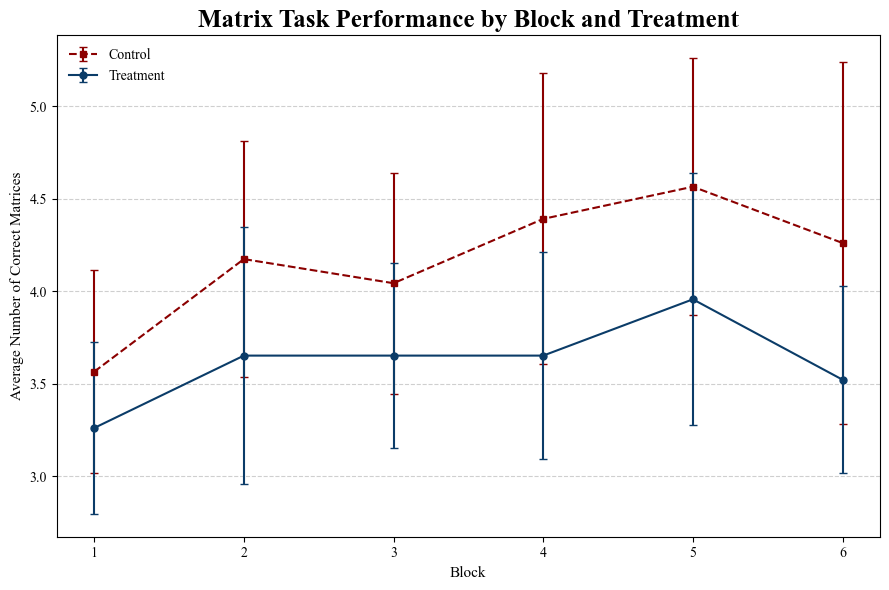

In [22]:
# Did performance vary during the experiment?
summary = (results_mtaskpp.groupby(["block", "pucktreatment"], observed=True)
           .agg(mean=("nrcorrect", "mean"), std=("nrcorrect", "std"), n=("nrcorrect", "size"))
           .reset_index())
summary["ci"] = 1.96 * summary["std"] / np.sqrt(summary["n"])

plt.figure(figsize=(9,6))
palette = {
    "treatment":  "#0b3c68",
    "control":    "#8b0000",}

for treat, grp in summary.groupby("pucktreatment", observed=True):
    style = "-o" if treat == "treatment" else "--s"
    plt.errorbar(grp["block"], grp["mean"], yerr=grp["ci"], color=palette[treat],
                 fmt=style, capsize=3, linewidth=1.5, markersize=5,
                 label=treat.capitalize())

plt.xlabel("Block", fontsize=11)
plt.ylabel("Average Number of Correct Matrices", fontsize=11)
plt.title("Matrix Task Performance by Block and Treatment")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.savefig(img_path+"/res_performance_mtask.png")

In [23]:
# Descriptives by treatment group
vars_to_check = {
            "Number of attempts": "nrattempts",
            "Correct": "nrcorrect",
            "Wrong": "nrwrong"
        }

latex_code = describe_by_group_to_latex(
        results_mtaskpp,
        vars_to_check = vars_to_check,
        group_col="pucktreatment",
        filename=save_dir+ "/mt_descriptives.tex",
        caption="Matrix task: descriptive statistics by treatment group",
        label="tab:m_descriptives",
)

## Visualising choices on the budgets

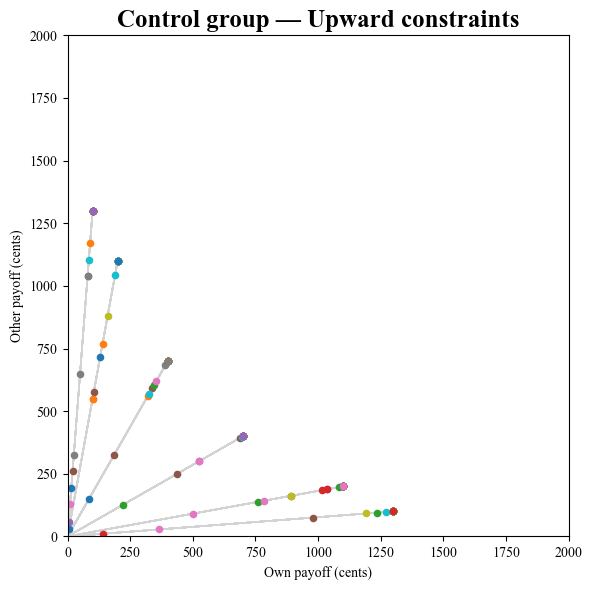

In [29]:
fig = plot_static_choice_panel(results_garp, direction=1, treatment="control")
plt.show()

In [31]:
plot_subject_choices_dashboard(results_garp)

## GARP violations

In [24]:
garp_ds["noise"]=0

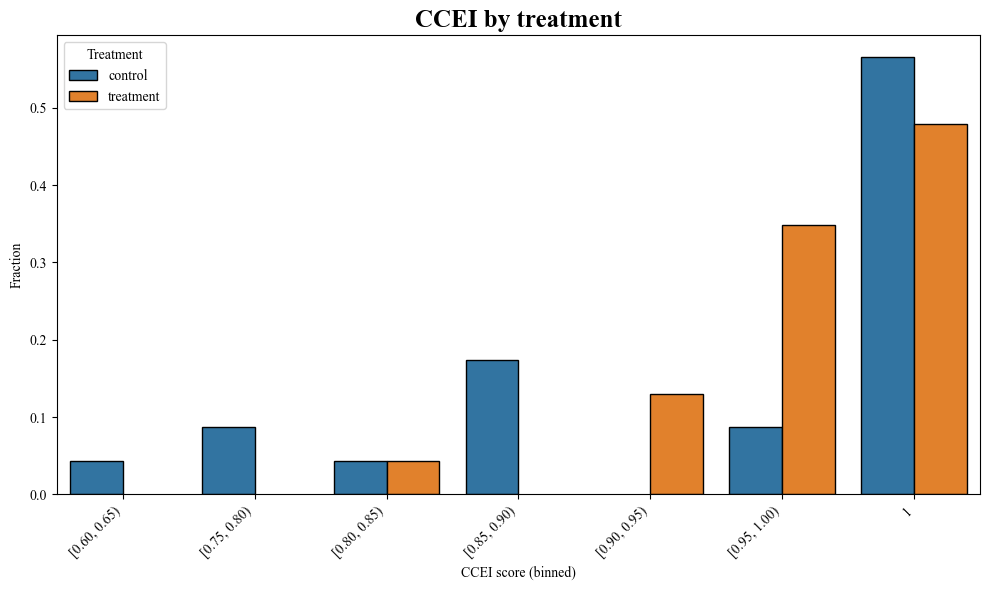

In [25]:
plot_index(garp_ds, group_by="pucktreatment", title="CCEI by treatment", bin_width = 0.05)

In [26]:
garp_ds.columns

Index(['id', 'index', 'session', 'ppnr', 'part', 'period', 'direction',
       'noisy_x', 'noisy_y', 'tijd', 'pogingen', 'max_self', 'max_other',
       'pucktreatment', 'slopeorder', 'price', 'frac_given', 'noise'],
      dtype='object')

In [27]:
garp_ds

,id,index,session,ppnr,part,period,direction,noisy_x,noisy_y,tijd,pogingen,max_self,max_other,pucktreatment,slopeorder,price,frac_given,noise
1,13,2,1,14,1,2,-1,165,564,14,1,560,800,control,1,0.7,0.705252,0
4,10,7,1,11,1,2,-1,560,0,6,1,560,800,treatment,1,0.7,0.000000,0
5,9,8,1,10,1,2,-1,460,143,14,3,560,800,control,1,0.7,0.178718,0
7,2,11,1,2,1,2,-1,410,214,17,2,560,800,control,1,0.7,0.267596,0
11,5,16,1,5,1,2,-1,364,279,9,2,560,800,treatment,1,0.7,0.349186,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,42,377,2,18,4,4,-1,630,0,6,1,630,420,control,2,1.5,0.000000,0
823,33,378,2,8,4,3,-1,610,0,5,2,610,610,control,2,1.0,0.000000,0
824,46,379,2,22,4,3,-1,610,0,10,3,610,610,control,2,1.0,0.000000,0
825,33,380,2,8,4,4,-1,460,113,7,2,630,420,control,2,1.5,0.269261,0


In [28]:
compute_index(garp_ds).CCEI

0     0.977151
1     1.000000
2     1.000000
3     1.000000
4     0.988224
5     0.799020
6     1.000000
7     1.000000
8     0.964286
9     1.000000
10    0.996454
11    0.987462
12    0.896213
13    0.900000
14    0.897500
15    0.925110
16    1.000000
17    1.000000
18    0.854000
19    1.000000
20    1.000000
21    1.000000
22    1.000000
23    1.000000
24    0.991997
25    1.000000
26    0.917672
27    0.767376
28    0.996136
29    1.000000
30    1.000000
31    0.983333
32    0.812766
33    0.994000
34    0.606061
35    0.846607
36    1.000000
37    1.000000
38    1.000000
39    1.000000
40    0.885246
41    1.000000
42    1.000000
43    1.000000
44    0.961295
45    1.000000
Name: CCEI, dtype: float64